In [1]:
#%reset
# Set path for module imports
import sys
# replace the path below with the absolute path to your `scattering/` folder
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation" #"/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

#%load_ext autoreload
#%autoreload 2

# Run this cell to import necessary libraries
import json
import yaml
import pickle
import logging
import numpy as np
import matplotlib.pyplot as plt


# --- Imports for the new interactive framework ---
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button, Textarea
from IPython.display import display

# --- Your Pipeline's Imports ---
# Make sure your scint_analysis package is importable
# (You may need to add its path using sys.path.insert)
#try:
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_component, gaussian_component
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses
#except ImportError as e:
#    logging.error(f"Could not import scint_analysis. Make sure it's in your Python path. {e}")

# --- 1. Configuration ---
# Set up basic logging to see pipeline output in the notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define the path to the configuration file for the analysis run
BURST_CONFIG_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/freya_dsa.yaml' #'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/FLITS/scintillation/configs/bursts/freya_dsa.yaml'

# Load the merged configuration from the YAML files
try:
    analysis_config = config.load_config(BURST_CONFIG_PATH)
    print("--- Loaded Configuration ---")
    print(json.dumps(analysis_config, indent=2))
except Exception as e:
    logging.error(f"Failed to load configuration: {e}")
    # Stop execution if config fails
    raise

# --- 2. Initialize the Pipeline Object ---
print("\n--- Initializing Scintillation Pipeline ---")
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

print("\n--- Initializing and Running Scintillation Pipeline ---")
# Create an instance of the main pipeline controller
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)

# --- 3. Prepare Data for Interactive Use ---
# This new step loads the data and populates scint_pipeline.masked_spectrum
scint_pipeline.prepare_data()

# --- 4. Run the Interactive Window Selector ---
# ==============================================================================
# Interactive On/Off-Pulse Window Selector
# ==============================================================================
# This tool allows you to visually select the on-pulse and off-pulse windows
# and save them directly to the burst's YAML configuration file.

if 'scint_pipeline' not in locals() or scint_pipeline.masked_spectrum is None:
    print("Please run the initial pipeline setup cells first.")
else:
    # --- Helper function to update the YAML file ---
    def update_rfi_config(config_path, key, value_list):
        try:
            with open(config_path, 'r') as f:
                config_data = yaml.safe_load(f)
            rfi_section = config_data.setdefault('analysis', {}).setdefault('rfi_masking', {})
            rfi_section[key] = value_list
            with open(config_path, 'w') as f:
                yaml.dump(config_data, f, default_flow_style=False, sort_keys=False)
            return f"Success! Updated '{key}' to {value_list} in {config_path.split('/')[-1]}"
        except Exception as e:
            return f"Error updating YAML: {e}"

    # --- Main Interactive Function ---
    def interactive_window_selector(pipeline_obj, config_path):
        spectrum = pipeline_obj.masked_spectrum
        time_series = spectrum.get_profile()
        time_axis = spectrum.times
        max_bin = len(time_axis) - 1
        total_duration = time_axis[-1] - time_axis[0]
        
        # Find the center of the pulse to center the zoom
        peak_time_bin = np.argmax(time_series.filled(0))
        center_time = time_axis[peak_time_bin]

        # --- Create Widgets ---
        on_pulse_slider = IntRangeSlider(value=[max_bin // 2, 3 * max_bin // 4], min=0, max=max_bin, step=1, description='On-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        off_pulse_slider = IntRangeSlider(value=[0, max_bin // 4], min=0, max=max_bin, step=1, description='Off-Pulse Bins:', style={'description_width': 'initial'}, layout={'width': '95%'})
        
        # NEW: A slider to control the zoom *width* around the pulse center
        zoom_width_slider = FloatSlider(
            value=total_duration,
            min=total_duration * 0.01, # Min zoom is 1% of total duration
            max=total_duration,
            step=total_duration / 200,
            description='Zoom Width (s):',
            readout_format='.3f',
            style={'description_width': 'initial'},
            layout={'width': '95%'}
        )
        
        save_button = Button(description="Save Windows to YAML", button_style='primary', icon='save')
        status_label = Label(value="Adjust sliders to select regions.")
        plot_output = Output()

        # --- Plotting Function ---
        def draw_plot(on_pulse_range, off_pulse_range, zoom_width):
            with plot_output:
                plot_output.clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(12, 5))
                
                # Calculate the zoom window centered on the peak
                zoom_min = center_time - (zoom_width / 2)
                zoom_max = center_time + (zoom_width / 2)
                
                ax.plot(time_axis, time_series, color='navy', label='Profile')
                ax.axvspan(time_axis[on_pulse_range[0]], time_axis[on_pulse_range[1]], color='cyan', alpha=0.4, label='On-Pulse')
                ax.axvspan(time_axis[off_pulse_range[0]], time_axis[off_pulse_range[1]], color='orange', alpha=0.4, label='Off-Pulse (Noise)')
                
                ax.set_title("On/Off-Pulse Window Selector")
                ax.set_xlabel("Time (s)"), ax.set_ylabel("Power")
                ax.grid(True, linestyle=':'), ax.legend()
                ax.set_xlim(zoom_min, zoom_max) # Apply the centered zoom
                plt.show()

        # --- Callbacks ---
        def on_change(change):
            draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

        def on_save_clicked(b):
            on_pulse_window = list(on_pulse_slider.value)
            off_pulse_window = list(off_pulse_slider.value)
            msg1 = update_rfi_config(config_path, 'manual_burst_window', on_pulse_window)
            msg2 = update_rfi_config(config_path, 'manual_noise_window', off_pulse_window)
            status_label.value = f"{msg1} | {msg2}"
            pipeline_obj.config['analysis']['rfi_masking']['manual_burst_window'] = on_pulse_window
            pipeline_obj.config['analysis']['rfi_masking']['manual_noise_window'] = off_pulse_window

        # --- Link widgets and display ---
        on_pulse_slider.observe(on_change, names='value')
        off_pulse_slider.observe(on_change, names='value')
        zoom_width_slider.observe(on_change, names='value') # Connect the new slider
        save_button.on_click(on_save_clicked)
        
        dashboard = VBox([zoom_width_slider, on_pulse_slider, off_pulse_slider, plot_output, HBox([save_button, status_label])])
        display(dashboard)
        draw_plot(on_pulse_slider.value, off_pulse_slider.value, zoom_width_slider.value)

    # --- Run the interactive tool ---
    interactive_window_selector(scint_pipeline, BURST_CONFIG_PATH)


INFO: Loading burst configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/freya_dsa.yaml
INFO: Loading telescope configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/../telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/
INFO: --- Preparing Data ---
INFO: Intermediate results will be cached in: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/
INFO: Loading and processing raw data...
INFO: Loading DynamicSpectrum fro

--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "freya",
  "input_data_path": "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/freya.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 8.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0,
      "manual_burst_window": [
        1249,
        1360
      ],
      "manual_noise_window": [
        0,
        624
      ]
    },
    "acf": {
      "num_subbands": 1,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": true,
      "enable_intra_pulse

INFO: RFI MASKING: Using manually specified on-pulse window: [1249, 1360]
INFO: Using symmetric noise window of duration 111 bins.
INFO: Using downsampled noise statistics from bins 71 to 78.


Manual window set to [1249, 1360]


Iterative RFI Masking in Frequency Domain:   0%|          | 0/5 [00:00<?, ?it/s]
INFO: Masked 0 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: --- Data Preparation Finished ---


INFO: Data already prepared. Skipping.
INFO: --- Starting Scintillation Pipeline for freya ---
INFO: Applying polynomial baseline subtraction...
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 111)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_on_pulse_diagnostic.png


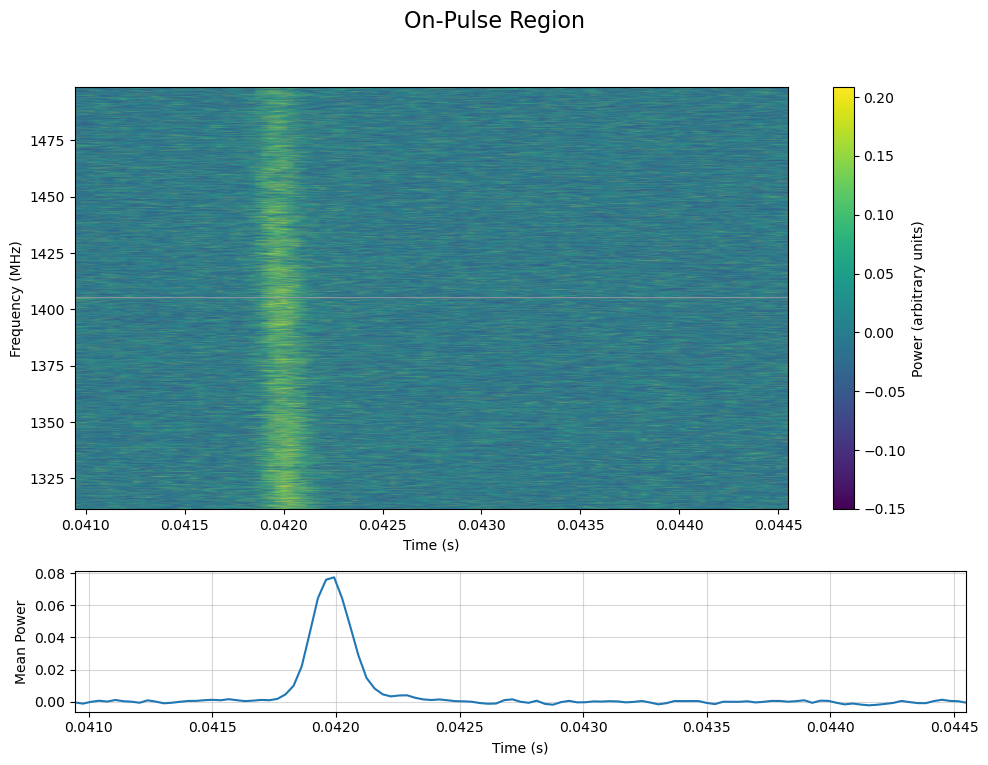

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 624)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_off_pulse_diagnostic.png


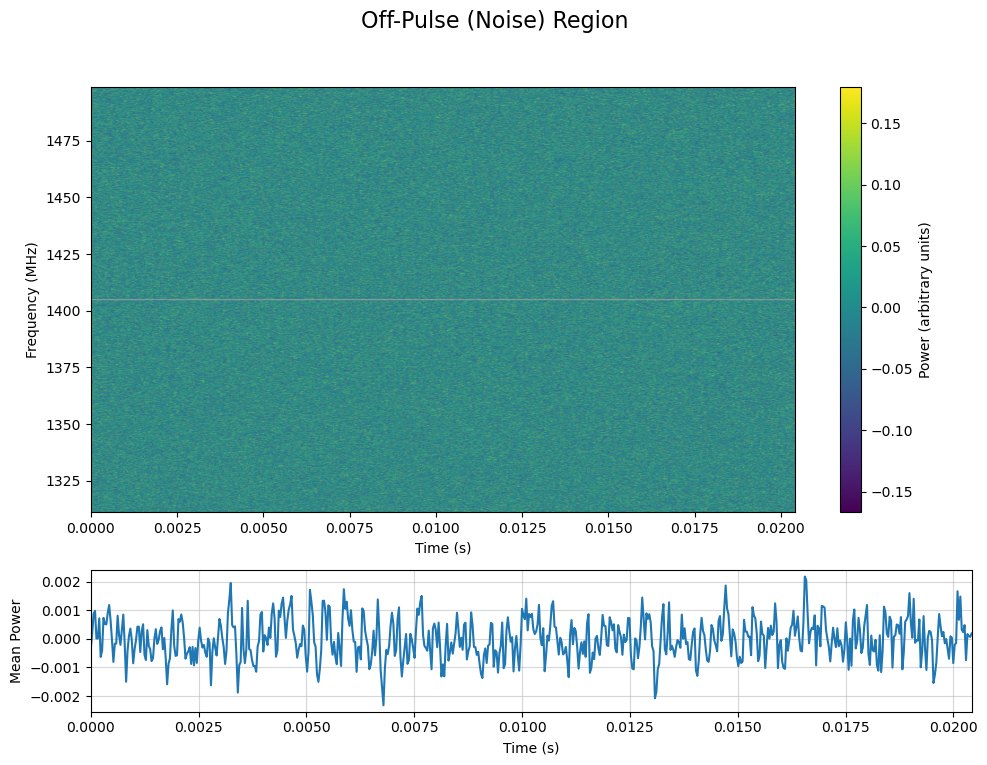

INFO: On/Off pulse diagnostic plots saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_baseline_diagnostic.png


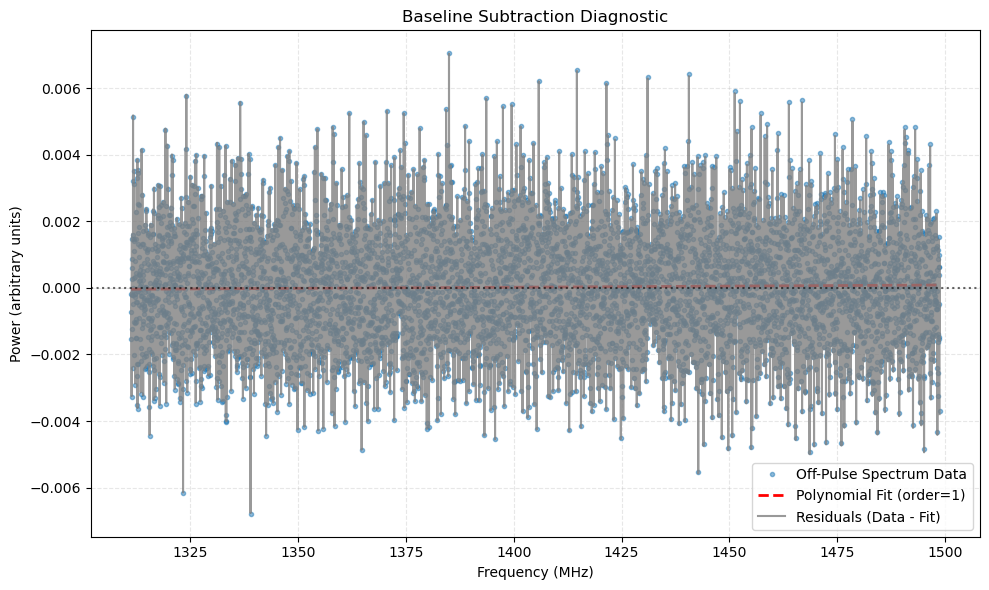

INFO: Characterizing off-pulse noise...
/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/scint_analysis/noise.py:145: UserWarning: NaNs detected – in‑painting with row/col medians.
  warnings.warn("NaNs detected – in‑painting with row/col medians.")
/Users/jakobfaber/.local/share/mamba/envs/chimedsa/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 1/1 [00:16<00:00, 16.73s/it]
INFO: Saved ACF results to cache: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl
INFO: 'halt_after_acf' is set to True. Halti

--- Pipeline Execution Finished ---


In [2]:
# --- 4. Run the Pipeline ---
# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

In [3]:
# ==============================================================================
# Manual ACF Fitting Notebook – hierarchical 1–3-component fitter  ✨
# ------------------------------------------------------------------------------
# • Choose up to THREE single-component models (Lorentzian, Gaussian,
#   Generalised-Lorentzian, Power-law) and build a composite fit on-the-fly.
# • Hard lower limit on all γ / σ sliders and bounds: 0.1.
# • Live initial-guess preview, lag-range sync, stored-fits printer, YAML export.
# ==============================================================================

import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit.models import ConstantModel
from ipywidgets import (
    IntSlider, FloatSlider, FloatRangeSlider, FloatText,
    Dropdown, Checkbox, VBox, HBox, Button, Output, Textarea, Label
)
from IPython.display import display

# ──────────────────────────────────────────────────────────────────────────────
# 0.  Import single-component model functions (from your scint_analysis pkg)
# ──────────────────────────────────────────────────────────────────────────────
from scint_analysis.analysis import (
    _make_noise_model,
    #lorentzian_model_1_comp,
    #gaussian_model_1_comp,
    calculate_acf,
    lorentzian_component,
    gaussian_component,
    lorentzian_generalised,
    power_law_model,
)

# ──────────────────────────────────────────────────────────────────────────────
# 1.  Load cached ACF data
# ──────────────────────────────────────────────────────────────────────────────
ACF_RESULTS_PATH = (
    "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl"
)
with open(ACF_RESULTS_PATH, "rb") as f:
    acf_results = pickle.load(f)

num_subbands = len(acf_results["subband_acfs"])
print(f"Loaded ACFs for {num_subbands} sub-bands.")

# ──────────────────────────────────────────────────────────────────────────────
# 2.  Library of single-component models
# ──────────────────────────────────────────────────────────────────────────────
MODEL_CONFIG = {
    #"Lorentzian": {
    #    "func": lorentzian_model_1_comp,
    #    "prefix": "l1_",
    #    "param_names": ["gamma1", "m1", "c1"],
    #},
    #"Gaussian": {
    #    "func": gaussian_model_1_comp,
    #    "prefix": "g1_",
    #    "param_names": ["sigma1", "m1", "c1"],
    #},
    "Lorentzian": {
        "func": lorentzian_component,
        "prefix": "l_",
        "param_names": ["gamma", "m"],
    },
    "Gaussian": {
        "func": gaussian_component,
        "prefix": "g_",
        "param_names": ["sigma", "m"],
    },
    "Gen-Lorentz": {
        "func": lorentzian_generalised,
        "prefix": "lg_",
        "param_names": ["gamma", "alpha", "m"], #"c1"],
    },
    "Power-Law": {
        "func": power_law_model,
        "prefix": "p_",
        "param_names": ["c", "n"],
    },
}

# ──────────────────────────────────────────────────────────────────────────────
# 3.  Widgets
# ──────────────────────────────────────────────────────────────────────────────
subband_slider = IntSlider(0, 0, num_subbands - 1, 1, description="Sub-band:")

prim_dd  = Dropdown(options=list(MODEL_CONFIG.keys()), value="Lorentzian", description="Model 1:")
add2_cb  = Checkbox(False, description="+2nd")
sec_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Gaussian",   description="Model 2:", disabled=True)
add3_cb  = Checkbox(False, description="+3rd")
thr_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Power-Law", description="Model 3:", disabled=True)

# enable / disable extra dropdowns
add2_cb.observe(lambda ch: setattr(sec_dd, "disabled", not ch["new"]), names="value")
add3_cb.observe(lambda ch: setattr(thr_dd, "disabled", not ch["new"]), names="value")

# lag-range widgets
max_lag = float(max(np.max(np.abs(l)) for l in acf_results["subband_lags_mhz"]))
fit_min_txt = FloatText(-max_lag, description="Min Lag:")
fit_max_txt = FloatText( max_lag, description="Max Lag:")
fit_rng_slider = FloatRangeSlider(value=(-max_lag, max_lag), min=-max_lag, max=max_lag,
                                  step=0.1, description="Fit Range Slider:")

ignore_err_cb = Checkbox(False, description="Ignore σ")

fit_btn   = Button(description="Perform Fit", button_style="success", icon="cogs")
print_btn = Button(description="Print Fits",  button_style="info",    icon="print")
save_btn  = Button(description="Save→YAML",   button_style="warning", icon="save")
plot_noise_btn = Button(description="Plot Noise Synthesis", button_style="info", icon="chart-area")


param_box  = VBox([])
plot_out   = Output()
results_tb = Textarea(layout={"width": "98%", "height": "200px"})
status_lbl = Label()
stats_lbl  = Label("Fit Stats: N/A")

# ──────────────────────────────────────────────────────────────────────────────
# 4.  Parameter-widget factory
# ──────────────────────────────────────────────────────────────────────────────
LOWER_WIDTH = 0.06  # hard floor for gamma / sigma

def _slider(desc, kind, val=0.5):
    if kind == "width":
        return FloatSlider(value=max(val, LOWER_WIDTH), min=LOWER_WIDTH, max=15,
                           step=0.01, description=desc)
    if kind == "m":
        return FloatSlider(value=val, min=0, max=4, step=0.01, description=desc)
    if kind == "c":
        return FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.001,
                           description=desc)
    if kind == "alpha":
        return FloatText(value=5/3, description=desc)
    if kind == "n":
        return FloatSlider(value=-2, min=-6, max=-1, step=0.1,
                           description=desc)
    return FloatText(value=val, description=desc)

def _make_widgets(model_key: str, idx: int):
    """Create ipywidgets for one component and hook them to live-preview."""
    cfg     = MODEL_CONFIG[model_key]
    prefix  = f"{cfg['prefix']}{idx}_"
    names   = cfg["param_names"]
    widgets = []

    i = 0
    while i < len(names):
        nm = names[i]

        # ---------- width sliders (gamma / sigma) ----------
        if nm.startswith(("gamma", "sigma")):
            w_width = _slider(prefix + nm, "width")
            w_width.observe(_on_visual_change, names="value")

            row = [w_width]

            # optional companion m-slider
            if i + 1 < len(names) and names[i + 1].startswith("m"):
                w_m = _slider(prefix + names[i + 1], "m")
                w_m.observe(_on_visual_change, names="value")
                row.append(w_m)
                i += 1                   # skip companion name

            widgets.append(HBox(row))

        # ---------- alpha ----------------------------------
        elif nm == "alpha":
            w_alpha = _slider(prefix + nm, "alpha")
            w_alpha.observe(_on_visual_change, names="value")
            widgets.append(w_alpha)

        # ---------- power-law index n -----------------------
        elif nm == "n":
            w_n = _slider(prefix + nm, "n")
            w_n.observe(_on_visual_change, names="value")
            widgets.append(w_n)

        # ---------- modulation index m ----------------------
        elif nm.startswith("m"):
            w_m = _slider(prefix + nm, "m")
            w_m.observe(_on_visual_change, names="value")
            widgets.append(w_m)

        # ---------- constant baseline c ---------------------
        elif nm.startswith("c"):
            w_c = _slider(prefix + nm, "c")
            w_c.observe(_on_visual_change, names="value")
            widgets.append(w_c)

        i += 1

    return widgets

def _refresh_param_box(*_):
    children = _make_widgets(prim_dd.value, 1)
    if add2_cb.value:
        children += _make_widgets(sec_dd.value, 2)
    if add3_cb.value:
        children += _make_widgets(thr_dd.value, 3)
    param_box.children = tuple(children)
    _draw_plot(initial_only=True)

for w in (prim_dd, sec_dd, thr_dd, add2_cb, add3_cb):
    w.observe(_refresh_param_box, names="value")

# ──────────────────────────────────────────────────────────────────────────────
# 5.  Helpers
# ──────────────────────────────────────────────────────────────────────────────
def _param_vals():
    vals = []
    for child in param_box.children:
        vals += [wid.value for wid in (child.children if isinstance(child, HBox) else (child,))]
    return vals

def _auto_bounds(params):
    for name, par in params.items():
        if any(key in name for key in ("gamma", "sigma")):
            par.set(min=LOWER_WIDTH)
        elif name.endswith("m") or name.endswith("_m"):
            par.set(min=0)
        elif "alpha" in name:
            par.set(min=0.1, max=6)

# ──────────────────────────────────────────────────────────────────────────────
# 6.  Plot helper (initial guess & best fit)
# ──────────────────────────────────────────────────────────────────────────────

def plot_noise_template_synthesis(subband_index):
    """
    Generates and plots the individual noise ACFs and their average.
    """
    noise_desc = scint_pipeline.noise_descriptor
    if not noise_desc:
        print("Noise descriptor not found. Please enable noise analysis.")
        return

    # Get config parameters
    n_rep = analysis_config.get('analysis', {}).get('noise', {}).get('template_n_draws', 25)
    max_lag_mhz = analysis_config.get('analysis', {}).get('acf', {}).get('max_lag_mhz', 45.0)
    
    # Get sub-band specific parameters
    sub_spec = scint_pipeline.masked_spectrum.power[subband_index, :] # Use one channel as representative
    chan_width = scint_pipeline.masked_spectrum.channel_width_mhz
    max_lag_bins_sub = int(max_lag_mhz / chan_width)

    # Generate and store the ACFs
    all_noise_acfs = []
    for _ in range(n_rep):
        noise_row = noise_desc.sample()[0]
        acf_obj = calculate_acf(
            np.ma.masked_invalid(noise_row),
            chan_width,
            off_burst_spectrum_mean=0.0,
            max_lag_bins=max_lag_bins_sub
        )
        if acf_obj:
            all_noise_acfs.append(acf_obj.acf)

    if not all_noise_acfs:
        print("Failed to generate any noise ACFs.")
        return

    all_noise_acfs = np.array(all_noise_acfs)
    mean_template = np.mean(all_noise_acfs, axis=0)
    lags = acf_obj.lags # Lags from the last generated ACF

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for noise_acf in all_noise_acfs:
        ax.plot(lags, noise_acf, color='gray', alpha=0.2)
    
    ax.plot(lags, mean_template, color='deepskyblue', lw=2.5, label=f'Mean Template (from {n_rep} draws)')
    ax.set_title(f"Noise Template Synthesis for Sub-band {subband_index}")
    ax.set_xlabel("Frequency Lag (MHz)")
    ax.set_ylabel("Autocorrelation")
    ax.legend()
    ax.grid(True, linestyle=':')
    plt.show()

def _draw_plot(initial_only=False, fit_res=None):
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None] * num_subbands)[sb]

    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x_fit, y_fit = lags[mask], acf[mask]

    with plot_out:
        plot_out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 6)) # Increased figure size for clarity
        ax.errorbar(lags, acf, yerr=None if errs is None or ignore_err_cb.value else errs,
                    fmt=".", ms=3, capsize=3, color="lightgray", label="All data", zorder=1)
        ax.plot(x_fit, y_fit, '-', ms=4, color="purple", alpha=0.6, label="Fit range", zorder=2)

        # initial-guess curve
        if initial_only and x_fit.size:
            vals, idx, guess = _param_vals(), 0, np.zeros_like(x_fit)
            sequence = [prim_dd.value] \
                     + ([sec_dd.value]  if add2_cb.value else []) \
                     + ([thr_dd.value]  if add3_cb.value else [])
            for key in sequence:
                # build initial-guess curve component-by-component
                cfg  = MODEL_CONFIG[key]
                npar = len(cfg["param_names"])          # ← define npar here
                guess += cfg["func"](x_fit, *vals[idx: idx + npar])
                idx   += npar                           # advance pointer

            ax.plot(x_fit, guess, c="pink", label="Initial guess", zorder=3)

        #if fit_res is not None:
        #    ax.plot(x_fit, fit_res.best_fit, "k-", lw=2,
        #            label="Best fit", zorder=4)
        if fit_res is not None:
            # Plot the total composite fit (the sum of all components)
            ax.plot(x_fit, fit_res.best_fit, "k-", lw=2.5, label="Best Composite Fit", zorder=10)

            # Plot individual components 
            components = fit_res.eval_components(x=x_fit)
            for prefix, component_curve in components.items():
                print(np.nanmean(component_curve))
                # Use different line styles and colors for clarity
                if 'tpl' in prefix:
                    style = {'color': 'deepskyblue', 'linestyle': '--', 'lw': 2, 'label': 'Noise Template Fit'}
                elif 'l' in prefix or 'g' in prefix: # Primary signal component
                    style = {'color': 'red', 'linestyle': ':', 'lw': 2, 'label': 'Signal Component 1'}
                else: # Other signal components
                    style = {'color': 'orange', 'linestyle': ':', 'lw': 2, 'label': f"Signal Comp. ({prefix.strip('_')})"}
                ax.plot(x_fit, component_curve, **style, zorder=5)

        # This part for axes and labels remains the same...
        idx0, idx1 = np.abs(lags - m0).argmin(), np.abs(lags - m1).argmin()
        ax.set_ylim(np.min(y_fit) - 0.05, np.max(y_fit) + 0.05)
        ax.set_xlim(m0 - (0.05 * (m1-m0)), m1 + (0.05 * (m1-m0))) # Add 5% padding
        ax.set_xlabel("Δν (MHz)")
        ax.set_ylabel("C_I")
        ax.grid(ls=":")
        ax.legend(loc="upper right")
        plt.show()

        fig, ax = plt.subplots(figsize=(10, 5))
        # Plot individual components 
        if fit_res is not None:
            ax.plot(x_fit, fit_res.best_fit, "k-", lw=2.5, label="Best Composite Fit", zorder=10)
            components = fit_res.eval_components(x=x_fit)
            for prefix, component_curve in components.items():
                print(np.nanmean(component_curve))
                # Use different line styles and colors for clarity
                if 'tpl' in prefix:
                    style = {'color': 'deepskyblue', 'linestyle': '--', 'lw': 2, 'label': 'Noise Template Fit'}
                    ax.plot(x_fit, component_curve, **style, zorder=5)
                elif 'l' in prefix or 'g' in prefix: # Primary signal component
                    style = {'color': 'red', 'linestyle': ':', 'lw': 2, 'label': 'Signal Component 1'}
                    ax.plot(x_fit, component_curve, **style, zorder=5)
                else: # Other signal components
                    style = {'color': 'orange', 'linestyle': ':', 'lw': 2, 'label': f"Signal Comp. ({prefix.strip('_')})"}
                    ax.plot(x_fit, component_curve, **style, zorder=5)
        ax.set_xlabel("Δν (MHz)")
        ax.set_ylabel("C_I")
        ax.grid(ls=":")
        ax.legend(loc="upper right")
        #ax.set_ylim(np.min(y_fit)-0.05, np.max(y_fit)+0.05)
        #ax.set_xlim(m0-2, m1+2)
        plt.show()

def _on_visual_change(change=None):
    """Redraw the initial-guess preview whenever a GUI control moves."""
    _draw_plot(initial_only=True)

# ---------------------------------------------------------------------------
# 7.  Lag-range textbox ⇆ slider synchronisation
# ---------------------------------------------------------------------------
def _sync_text_to_slider(_):
    if fit_min_txt.value < fit_max_txt.value:
        fit_rng_slider.value = (fit_min_txt.value, fit_max_txt.value)

def _sync_slider_to_text(ch):
    fit_min_txt.value, fit_max_txt.value = (round(ch["new"][0], 2),
                                            round(ch["new"][1], 2))

fit_min_txt.observe(_sync_text_to_slider, names="value")
fit_max_txt.observe(_sync_text_to_slider, names="value")
fit_rng_slider.observe(_sync_slider_to_text, names="value")

fit_rng_slider.observe(_on_visual_change, names="value")
fit_min_txt.observe(_on_visual_change, names="value")
fit_max_txt.observe(_on_visual_change, names="value")

subband_slider.observe(_on_visual_change, names="value")
# ---------------------------------------------------------------------------
# 8.  Fit callback
# ---------------------------------------------------------------------------
all_fits = {}

def _on_fit(_):
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None] * num_subbands)[sb]
    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x, y = lags[mask], acf[mask]
    wts = None if (ignore_err_cb.value or errs is None) else 1.0 / np.maximum(errs[mask], 1e-9)
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])
    
    # --- START: MODIFIED MODEL BUILDING ---
    
    # Build the signal part of the model from GUI selections
    signal_model, params = None, None
    vals, idx = _param_vals(), 0
    for i, key in enumerate(comps, start=1):
        cfg = MODEL_CONFIG[key]
        m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
        p = m.make_params()
        n = len(cfg["param_names"])
        for val, pname in zip(vals[idx : idx + n], p.keys()):
            p[pname].set(value=val)
        idx += n
        _auto_bounds(p)
        signal_model, params = (m, p) if signal_model is None else (signal_model + m, params.update(p) or signal_model)

    # Now, add a single, shared constant model for the baseline
    if signal_model is not None:
        const_model = ConstantModel(prefix='c_')
        params.update(const_model.make_params(c=0.0)) # Add the constant parameter
        composite_model = signal_model + const_model
    else:
        # Handle case where no signal model was selected
        composite_model = ConstantModel(prefix='c_')
        params = composite_model.make_params(c=0.0)

    # --- END: MODIFIED MODEL BUILDING ---

    # Perform the fit
    result = composite_model.fit(y, params, x=x, weights=wts)
    all_fits[(sb, tuple(comps))] = result

    # Update GUI with results (this part is unchanged)
    mean_sigma = np.nan if wts is None else float(1 / np.mean(wts))
    stats_lbl.value = f"χ²ᵣ = {result.redchi:.3f}   |   BIC = {result.bic:.2f}   |   ⟨σ⟩ = {mean_sigma:.4f}"
    _draw_plot(fit_res=result)

# ---------------------------------------------------------------------------
# 9.  Print & YAML callbacks
# ---------------------------------------------------------------------------
def _on_print(_):
    out = []
    for (sb, comps), res in all_fits.items():
        cf = acf_results["subband_center_freqs_mhz"][sb]
        out.append(f"--- Sub-band {sb} @ {cf:.2f} MHz :: {' + '.join(comps)}")
        for n, p in res.params.items():
            serr = p.stderr if p.stderr is not None else 0
            out.append(f"  {n}: {p.value:.4g} ± {serr:.2g}")
        out.append("")
    results_tb.value = "\n".join(out) if out else "No fits yet."

BURST_CONFIG_PATH = (
    "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/freya_dsa.yaml"
)

def _on_save(_):
    sb = subband_slider.value
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])
    key  = (sb, tuple(comps))
    if key not in all_fits:
        status_lbl.value = "Run a fit first."
        return
    res  = all_fits[key]
    tag  = "+".join(comps)
    entry = {
        "reference_frequency_mhz": float(acf_results["subband_center_freqs_mhz"][sb]),
        "best_fit_params": {n: float(p.value) for n, p in res.params.items()},
        "redchi": float(res.redchi),
        "bic": float(res.bic),
    }
    cfg = yaml.safe_load(open(BURST_CONFIG_PATH)) or {}
    cfg.setdefault("analysis", {}).setdefault("stored_fits", {}).setdefault(f"subband_{sb}", {})[tag] = entry
    yaml.safe_dump(cfg, open(BURST_CONFIG_PATH, "w"), sort_keys=False)
    status_lbl.value = f"Saved under subband_{sb} :: {tag}"

def _on_plot_noise_clicked(b):
    plot_noise_template_synthesis(subband_slider.value)

# ---------------------------------------------------------------------------
# 10.  Wire callbacks & build dashboard
# ---------------------------------------------------------------------------
fit_btn.on_click(_on_fit)
print_btn.on_click(_on_print)
save_btn.on_click(_on_save)
plot_noise_btn.on_click(_on_plot_noise_clicked)

fit_range_box = VBox([
    Label("Fit Lag Range (MHz):"),
    HBox([fit_min_txt, fit_max_txt]),
    fit_rng_slider,
])

dashboard = VBox([
    HBox([subband_slider, prim_dd, add2_cb, sec_dd, add3_cb, thr_dd]),
    fit_range_box,
    Label("Component Parameters (γ / σ, m, α, n, c):"),
    param_box,
    HBox([fit_btn, print_btn, save_btn, plot_noise_btn]),
    status_lbl,
    stats_lbl,
    plot_out,
    results_tb,
])

display(dashboard)
_refresh_param_box()  # populate sliders & preview



Loaded ACFs for 1 sub-bands.


/Users/jakobfaber/.local/share/mamba/envs/chimedsa/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
